In [19]:
import pandas as pd

df = pd.read_csv('C:/Users/Debrachoubey/PycharmProjects/pythonProject/first_100k_records_europe.csv')
# Step 1: Drop unnecessary columns
columns_to_drop = ['transaction_id', 'customer_id', 'card_number', 'device_fingerprint', 'ip_address', 'currency' , 'city' , 'city_size' ,'high_risk_merchant' , 'timestamp']
df_cleaned = df.drop(columns=columns_to_drop)
#Step 2: Convert timestamp to datetime
#df_cleaned['timestamp'] = pd.to_datetime(df_cleaned['timestamp'])

# Extract new features from timestamp
#df_cleaned['transaction_hour'] = df_cleaned['timestamp'].dt.hour
#df_cleaned['transaction_day'] = df_cleaned['timestamp'].dt.day
#df_cleaned['transaction_weekday'] = df_cleaned['timestamp'].dt.weekday  # Monday=0, Sunday=6
#df_cleaned['transaction_weekend'] = df_cleaned['transaction_weekday'] >= 5  # True if Saturday or Sunday
# Extract time of day (Morning, Afternoon, Evening, Night)
def time_of_day(hour):
    if 5 <= hour < 12:
        return "Morning"
    elif 12 <= hour < 17:
        return "Afternoon"
    elif 17 <= hour < 21:
        return "Evening"
    else:
        return "Night"

df_cleaned['time_of_day'] = df_cleaned['transaction_hour'].apply(time_of_day)
#df_cleaned.to_csv('output.csv', index=False)  # Set index=False to avoid saving the index column

#print("CSV file saved successfully!")
# Step 3: Extract velocity_last_hour details (JSON-like data)
import ast

def extract_velocity_features(value):
    if isinstance(value, str):  # If the column contains dictionary-like strings
        try:
            value = ast.literal_eval(value)  # Convert string to dictionary
            return pd.Series([value.get('num_transactions', 0), value.get('total_amount', 0.0)])
        except:
            return pd.Series([0, 0.0])  # Handle errors gracefully
    else:
        return pd.Series([0, 0.0])

df_cleaned[['num_transactions_last_hour', 'total_amount_last_hour']] = df_cleaned['velocity_last_hour'].apply(extract_velocity_features)
df_cleaned.drop(columns=['velocity_last_hour'], inplace=True)  # Remove original JSON-like column
print(df_cleaned.dtypes)  # Identify boolean columns

# Step 4: Encode categorical variables (One-Hot Encoding for nominal, Label Encoding for ordinal if needed)
categorical_columns = ['merchant_category', 'merchant_type', 'country','card_type', 'device', 'channel' , 'time_of_day']
df_encoded = pd.get_dummies(df_cleaned,columns=categorical_columns, drop_first=True)
# Step 5: Check for correlations among numerical features
#correlation_matrix = df_encoded.corr()

merchant_category              object
merchant_type                  object
merchant                       object
amount                        float64
country                        object
card_type                      object
card_present                     bool
device                         object
channel                        object
distance_from_home              int64
transaction_hour                int64
weekend_transaction              bool
is_fraud                         bool
time_of_day                    object
num_transactions_last_hour    float64
total_amount_last_hour        float64
dtype: object


In [2]:
pip install ace_tools

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
pip install seaborn


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


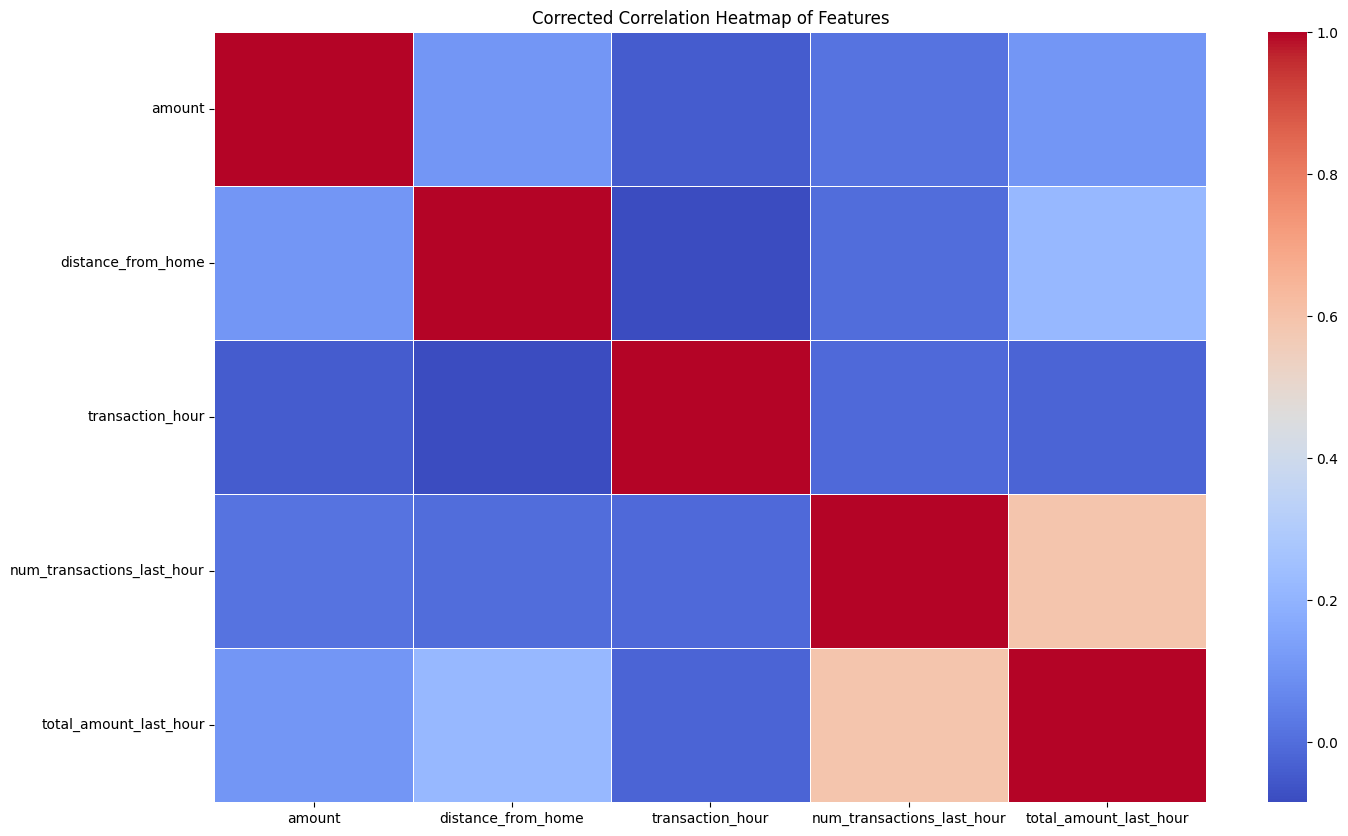

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Step 1: Select Only Numerical Columns
numerical_columns = df_encoded.select_dtypes(include=['int64', 'float64']).columns
correlation_matrix = df_encoded[numerical_columns].corr()

# Step 2: Plot Heatmap
plt.figure(figsize=(16, 10))  # Increase figure size
sns.heatmap(
    correlation_matrix,
    annot=False,  # Set to True if you want to see correlation values
    cmap='coolwarm',
    linewidths=0.5
)
plt.title("Corrected Correlation Heatmap of Features")
plt.show()

                            amount  distance_from_home  transaction_hour  \
amount                         1.0                 NaN               NaN   
distance_from_home             NaN                 1.0               NaN   
transaction_hour               NaN                 NaN               1.0   
num_transactions_last_hour     NaN                 NaN               NaN   
total_amount_last_hour         NaN                 NaN               NaN   

                            num_transactions_last_hour  total_amount_last_hour  
amount                                             NaN                     NaN  
distance_from_home                                 NaN                     NaN  
transaction_hour                                   NaN                     NaN  
num_transactions_last_hour                    1.000000                0.591622  
total_amount_last_hour                        0.591622                1.000000  


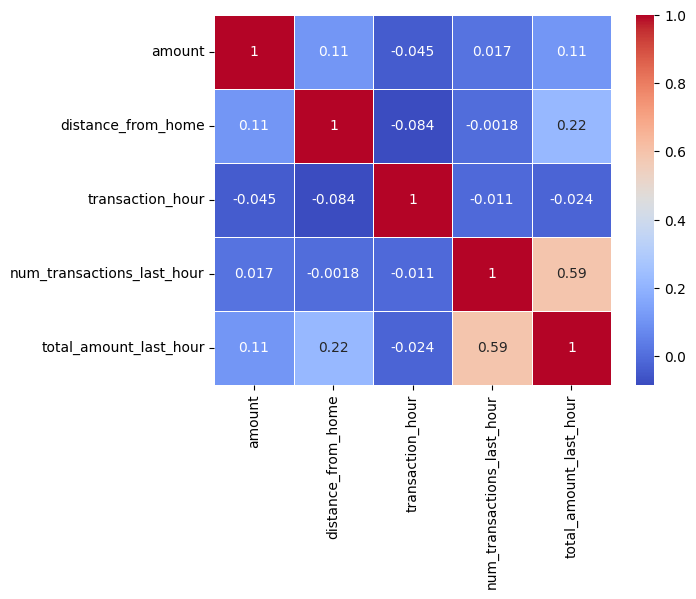

In [21]:
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
strong_corr = correlation_matrix[abs(correlation_matrix) > 0.5]
print(strong_corr)


<Axes: xlabel='num_transactions_last_hour', ylabel='total_amount_last_hour'>

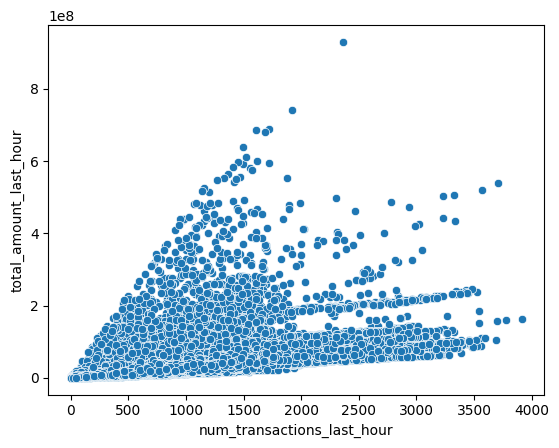

In [23]:
import seaborn as sns
sns.scatterplot(x=df_encoded['num_transactions_last_hour'], y=df_encoded['total_amount_last_hour'])


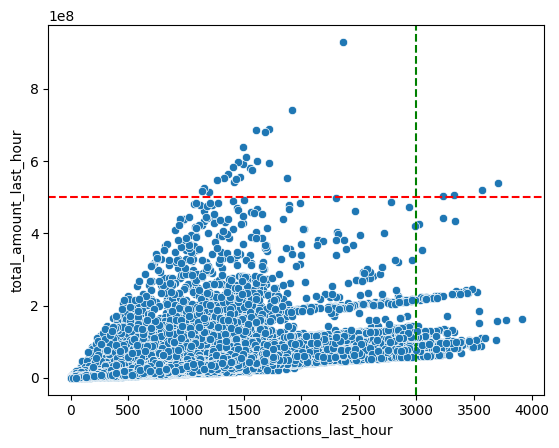

In [24]:
sns.scatterplot(x=df_encoded['num_transactions_last_hour'], y=df_encoded['total_amount_last_hour'])
plt.axhline(y=5e8, color='r', linestyle='--')  # Marking a threshold
plt.axvline(x=3000, color='g', linestyle='--')  # Marking a threshold
plt.show()


In [25]:
df_encoded[['num_transactions_last_hour', 'total_amount_last_hour']].corr()


,num_transactions_last_hour,total_amount_last_hour
num_transactions_last_hour,1.000000,0.591622
total_amount_last_hour,0.591622,1.000000


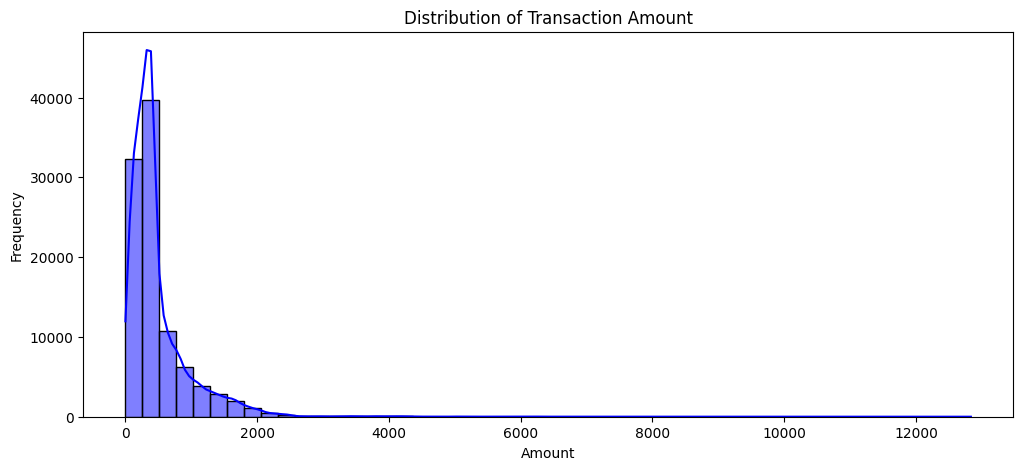

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distribution of 'amount'
plt.figure(figsize=(12, 5))
sns.histplot(df_cleaned['amount'], bins=50, kde=True, color='blue')
plt.title("Distribution of Transaction Amount")
plt.xlabel("Amount")
plt.ylabel("Frequency")
plt.show()


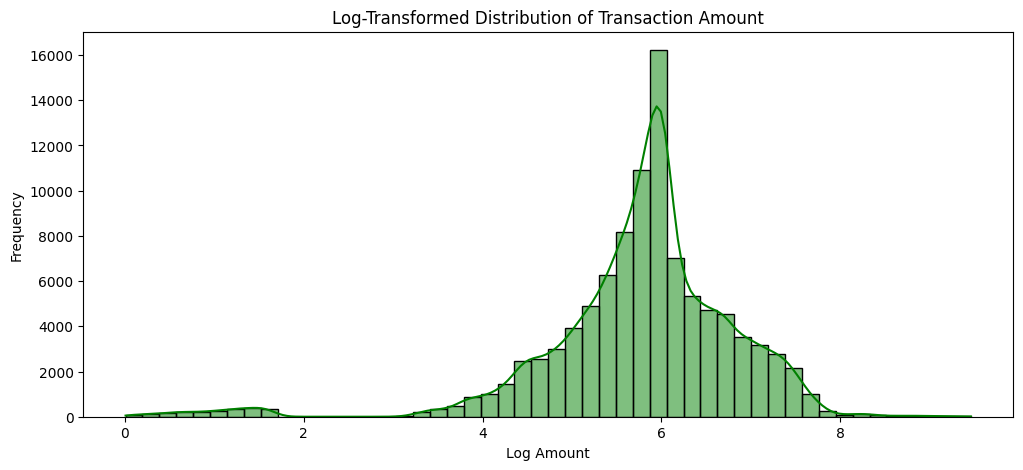

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Apply log transformation
df_cleaned['log_amount'] = np.log1p(df_encoded['amount'])  # log(1 + amount) to avoid log(0) errors

# Plot the transformed distribution
plt.figure(figsize=(12, 5))
sns.histplot(df_cleaned['log_amount'], bins=50, kde=True, color='green')
plt.title("Log-Transformed Distribution of Transaction Amount")
plt.xlabel("Log Amount")
plt.ylabel("Frequency")
plt.show()


In [29]:
import numpy as np
#from category_encoders import TargetEncoder
#from sklearn.preprocessing import OneHotEncoder

# Step 1: Drop Weakly Correlated Features
df_selected = df_cleaned.drop(columns=['transaction_hour','amount'], errors='ignore')

# Step 2: Define Thresholds for Anomalous Transactions
high_transactions_threshold = df_selected['num_transactions_last_hour'].quantile(0.95)  # Top 5%
high_amount_threshold = df_selected['total_amount_last_hour'].quantile(0.95)  # Top 5%
long_distance_threshold = df_selected['distance_from_home'].quantile(0.95)  # Top 5%

# Step 3: Create Fraud Indicators

# High Transaction Flag: User made an unusually high number of transactions in the last hour
df_selected['high_transaction_flag'] = (
    df_selected['num_transactions_last_hour'] > high_transactions_threshold
).astype(int)

# High Spending Flag: User spent an unusually high amount in the last hour
df_selected['high_spending_flag'] = (
    df_selected['total_amount_last_hour'] > high_amount_threshold
).astype(int)

# Long Distance Spending Flag: Large amount spent far from home
df_selected['long_distance_spender'] = (
    (df_selected['distance_from_home'] > long_distance_threshold) & 
    (df_selected['log_amount'] > high_amount_threshold)
).astype(int)

# Velocity-Based Risk Score: Combine transactions & amount in one feature
df_selected['velocity_risk_score'] = (
    df_selected['num_transactions_last_hour'] * 0.5 + df_selected['total_amount_last_hour'] * 0.5
)



# Step 5: Encode Categorical Features
from sklearn.preprocessing import LabelEncoder
categorical_columns = ['merchant_category', 'merchant_type', 'merchant', 'country', 'card_type', 'card_present','device', 'channel']
for col in categorical_columns:
    if col in df_selected.columns:
        df_selected[col] = LabelEncoder().fit_transform(df_selected[col])


# Fixing the encoding process with error handling and checking for column existence

#from sklearn.preprocessing import OneHotEncoder

# Define categorical columns and encoding strategy
#target_encode_cols = ['merchant_category', 'merchant_type', 'merchant', 'card_type']  # Target Encoding
#drop_cols = ['country']  # Dropped due to minimal impact
#binary_encode_cols = ['card_present']  # Binary Encoding (0/1)
#one_hot_encode_cols = ['device', 'channel']  # Selective One-Hot Encoding

# Apply Target Encoding manually (since category_encoders is unavailable)
#for col in target_encode_cols:
    #if col in df_selected.columns:
       # fraud_rates = df_selected.groupby(col)['is_fraud'].mean()
        #df_selected[col] = df_selected[col].map(fraud_rates)

# Apply Binary Encoding (0 = No, 1 = Yes) if the column exists
#if 'card_present' in df_selected.columns:
    #df_selected['card_present'] = df_selected['card_present'].astype(int)

# Apply One-Hot Encoding (for high-risk categories only) if columns exist
#available_one_hot_encode_cols = [col for col in one_hot_encode_cols if col in df_selected.columns]

#if available_one_hot_encode_cols:
    #one_hot_encoder = OneHotEncoder(sparse_output=False, drop='first')  # Drop first to avoid dummy variable trap
    #one_hot_encoded = one_hot_encoder.fit_transform(df_selected[available_one_hot_encode_cols])

    # Convert One-Hot Encoded data to DataFrame
    #one_hot_encoded_df = pd.DataFrame(one_hot_encoded, columns=one_hot_encoder.get_feature_names_out(available_one_hot_encode_cols))

    # Drop original one-hot encoded columns and concatenate new encoded features
    #df_selected = df_selected.drop(columns=available_one_hot_encode_cols)
    #df_selected = pd.concat([df_selected, one_hot_encoded_df], axis=1)

# Drop unnecessary columns if they exist
#df_selected = df_selected.drop(columns=[col for col in drop_cols if col in df_selected.columns], errors='ignore')

# Display updated dataset
#tools.display_dataframe_to_user(name="Encoded Fraud Dataset", dataframe=df_selected)


# Display the processed dataset
from IPython.display import display

# Display the cleaned DataFrame
display(df_selected.head())




,merchant_category,merchant_type,merchant,country,card_type,card_present,device,channel,distance_from_home,weekend_transaction,is_fraud,time_of_day,num_transactions_last_hour,total_amount_last_hour,log_amount,high_transaction_flag,high_spending_flag,long_distance_spender,velocity_risk_score
0,7,6,100,1,3,0,3,2,0,False,False,Night,352.0,8.690903e+06,6.720618,0,0,0,4.345628e+06
1,4,11,25,0,2,0,3,2,0,False,False,Night,600.0,1.766378e+07,6.273952,0,0,0,8.832190e+06
2,5,13,65,1,0,0,0,0,0,False,False,Night,181.0,1.715528e+06,5.590726,0,0,0,8.578547e+05
3,1,3,81,1,3,0,4,2,1,False,False,Night,24.0,7.220302e+06,6.493603,0,0,0,3.610163e+06
4,7,0,7,1,4,0,7,2,0,False,False,Night,235.0,3.605757e+06,7.021120,0,0,0,1.802996e+06


In [13]:
pip install category_encoders

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [30]:
from sklearn.preprocessing import StandardScaler

# Select features that need scaling
features_to_scale = ['log_amount', 'num_transactions_last_hour', 'total_amount_last_hour', 'velocity_risk_score']

# Initialize the scaler
scaler = StandardScaler()

# Apply standard scaling
df_selected[features_to_scale] = scaler.fit_transform(df_selected[features_to_scale])

# Display the processed dataset
from IPython.display import display

# Display the cleaned DataFrame
display(df_selected.head())


,merchant_category,merchant_type,merchant,country,card_type,card_present,device,channel,distance_from_home,weekend_transaction,is_fraud,time_of_day,num_transactions_last_hour,total_amount_last_hour,log_amount,high_transaction_flag,high_spending_flag,long_distance_spender,velocity_risk_score
0,7,6,100,1,3,0,3,2,0,False,False,Night,-0.824883,-0.559456,0.868403,0,0,0,-0.559465
1,4,11,25,0,2,0,3,2,0,False,False,Night,-0.347132,-0.269257,0.460524,0,0,0,-0.269261
2,5,13,65,1,0,0,0,0,0,False,False,Night,-1.154300,-0.785053,-0.163373,0,0,0,-0.785064
3,1,3,81,1,3,0,4,2,1,False,False,Night,-1.456747,-0.607018,0.661101,0,0,0,-0.607037
4,7,0,7,1,4,0,7,2,0,False,False,Night,-1.050273,-0.723919,1.142810,0,0,0,-0.723930


In [31]:
print(df_encoded.shape)  # Check number of rows in df_encoded
print(df_cleaned.shape)  # Check number of rows in df_selected

(100000, 50)
(100000, 17)


In [32]:
print(df_cleaned.columns)  # Check available columns

Index(['merchant_category', 'merchant_type', 'merchant', 'amount', 'country',
       'card_type', 'card_present', 'device', 'channel', 'distance_from_home',
       'transaction_hour', 'weekend_transaction', 'is_fraud', 'time_of_day',
       'num_transactions_last_hour', 'total_amount_last_hour', 'log_amount'],
      dtype='object')


In [33]:
# Count the number of fraud and legit transactions in the 'is_fraud' column
fraud_counts = df_selected['is_fraud'].value_counts()

# Display the processed dataset
from IPython.display import display

# Display the cleaned DataFrame
display(fraud_counts)



is_fraud
False    92932
True      7068
Name: count, dtype: int64

C:\Users\Debrachoubey\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:11:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



🔹 XGBoost Classification Report:
              precision    recall  f1-score       support
False          0.996326  0.972776  0.984410  27880.000000
True           0.726880  0.952830  0.824658   2120.000000
accuracy       0.971367  0.971367  0.971367      0.971367
macro avg      0.861603  0.962803  0.904534  30000.000000
weighted avg   0.977286  0.971367  0.973121  30000.000000


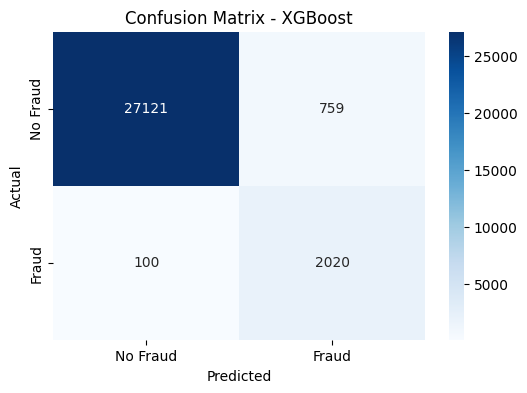

In [35]:
# Import necessary libraries
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import pandas as pd

# Define Features & Target
X = df_selected.drop(columns=['is_fraud'])
y = df_selected['is_fraud']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Calculate scale_pos_weight (Legit cases / Fraud cases)
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

# Train XGBoost with Class Weighting
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    scale_pos_weight=scale_pos_weight,  # Adjust class imbalance
    eval_metric="logloss",
    use_label_encoder=False,
    random_state=42
)

# Train the model
xgb_model.fit(X_train, y_train)

# Predictions
y_pred = xgb_model.predict(X_test)

# Model Evaluation
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred, output_dict=True)

# Convert classification report to DataFrame
class_report_df = pd.DataFrame(class_report).transpose()

import pandas as pd

# Convert classification report to DataFrame
class_report_df = pd.DataFrame(class_report).transpose()

# Print the classification report
print("\n🔹 XGBoost Classification Report:")
print(class_report_df)

import seaborn as sns
import matplotlib.pyplot as plt

# Plot Confusion Matrix as a Heatmap
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["No Fraud", "Fraud"], yticklabels=["No Fraud", "Fraud"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - XGBoost")
plt.show()



In [ ]:
pip install xgboost

In [ ]:
pip install sklearn

In [ ]:
pip install sklearn

In [ ]:
pip install scikit-learn

In [34]:
from sklearn.preprocessing import LabelEncoder

# Convert 'time_of_day' to categorical encoding
if 'time_of_day' in df_selected.columns:
    df_selected['time_of_day'] = LabelEncoder().fit_transform(df_selected['time_of_day'])


In [36]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Define Features & Target
X = df_selected.drop(columns=['is_fraud'])
y = df_selected['is_fraud']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Calculate scale_pos_weight (Legit cases / Fraud cases)
scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

# Define Baseline Model
xgb_baseline = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    scale_pos_weight=scale_pos_weight,
    eval_metric="logloss",
    use_label_encoder=False,
    random_state=42
)

# Train Model
xgb_baseline.fit(X_train, y_train)

# Predictions
y_pred_baseline = xgb_baseline.predict(X_test)

# Evaluate Baseline Model
print("Baseline Model Performance:")
print(classification_report(y_test, y_pred_baseline))


C:\Users\Debrachoubey\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:11:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Baseline Model Performance:
              precision    recall  f1-score   support

       False       1.00      0.97      0.98     27880
        True       0.73      0.95      0.82      2120

    accuracy                           0.97     30000
   macro avg       0.86      0.96      0.90     30000
weighted avg       0.98      0.97      0.97     30000



In [ ]:
from sklearn.model_selection import GridSearchCV

# Define Hyperparameter Grid
param_grid = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [4, 6, 8],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.3],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Initialize XGBoost Model
xgb_model = xgb.XGBClassifier(scale_pos_weight=scale_pos_weight, eval_metric="logloss", use_label_encoder=False, random_state=42)

# Grid Search
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='f1',  # Use F1-score to balance precision and recall
    cv=3,  # 3-fold cross-validation
    verbose=2,
    n_jobs=-1  # Use all available cores
)

# Fit Grid Search
grid_search.fit(X_train, y_train)

# Print Best Parameters
print("Best Parameters Found:")
print(grid_search.best_params_)

# Get Best Model
best_xgb = grid_search.best_estimator_

# Make Predictions
y_pred_tuned = best_xgb.predict(X_test)

# Evaluate Tuned Model
print("\nTuned Model Performance:")
print(classification_report(y_test, y_pred_tuned))


Fitting 3 folds for each of 2187 candidates, totalling 6561 fits


In [38]:
# Define Default Best Parameters
best_params_ = {
    'n_estimators': 100,
    'learning_rate': 0.1,
    'max_depth': 6,
    'min_child_weight': 1,
    'gamma': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8
}


In [39]:
import xgboost as xgb
from sklearn.metrics import f1_score

# Possible values to test
weights_to_test = [1, scale_pos_weight, scale_pos_weight * 2, scale_pos_weight * 3]

best_f1 = 0
best_weight = None

for weight in weights_to_test:
    print(f"\n Testing scale_pos_weight = {weight}")

    # Train XGBoost model
    xgb_model = xgb.XGBClassifier(
        n_estimators=best_params_['n_estimators'],
        learning_rate=best_params_['learning_rate'],
        max_depth=best_params_['max_depth'],
        min_child_weight=best_params_['min_child_weight'],
        gamma=best_params_['gamma'],
        subsample=best_params_['subsample'],
        colsample_bytree=best_params_['colsample_bytree'],
        scale_pos_weight=weight,
        eval_metric="logloss",
        use_label_encoder=False,
        random_state=42
    )

    # Train and Predict
    xgb_model.fit(X_train, y_train)
    y_pred = xgb_model.predict(X_test)

    # Compute F1-score
    f1 = f1_score(y_test, y_pred)
    print(f"F1-score: {f1}")

    # Keep track of best weight
    if f1 > best_f1:
        best_f1 = f1
        best_weight = weight

print(f"\n Best scale_pos_weight: {best_weight}")



 Testing scale_pos_weight = 1


C:\Users\Debrachoubey\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:12:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


F1-score: 0.9229229229229229

 Testing scale_pos_weight = 13.147130153597413


C:\Users\Debrachoubey\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:12:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


F1-score: 0.8292481977342946

 Testing scale_pos_weight = 26.294260307194826


C:\Users\Debrachoubey\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:12:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


F1-score: 0.7660286192157592

 Testing scale_pos_weight = 39.441390460792235


C:\Users\Debrachoubey\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:12:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


F1-score: 0.7194845899355737

 Best scale_pos_weight: 1


In [40]:
# Train Final XGBoost Model with Best scale_pos_weight
xgb_final = xgb.XGBClassifier(
    n_estimators=best_params_['n_estimators'],
    learning_rate=best_params_['learning_rate'],
    max_depth=best_params_['max_depth'],
    min_child_weight=best_params_['min_child_weight'],
    gamma=best_params_['gamma'],
    subsample=best_params_['subsample'],
    colsample_bytree=best_params_['colsample_bytree'],
    scale_pos_weight=best_weight,  # Use the best found weight
    eval_metric="logloss",
    use_label_encoder=False,
    random_state=42
)

# Train the model
xgb_final.fit(X_train, y_train)


C:\Users\Debrachoubey\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:13:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0.1, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [41]:
# Make Predictions
y_pred_final = xgb_final.predict(X_test)
y_pred_proba_final = xgb_final.predict_proba(X_test)[:, 1]  # Get probability scores for fraud detection


In [42]:
from sklearn.metrics import classification_report

# Print Classification Report
print("\n🔹 Final XGBoost Model Performance:")
print(classification_report(y_test, y_pred_final))



🔹 Final XGBoost Model Performance:
              precision    recall  f1-score   support

       False       0.99      1.00      0.99     27880
        True       0.98      0.87      0.92      2120

    accuracy                           0.99     30000
   macro avg       0.99      0.93      0.96     30000
weighted avg       0.99      0.99      0.99     30000



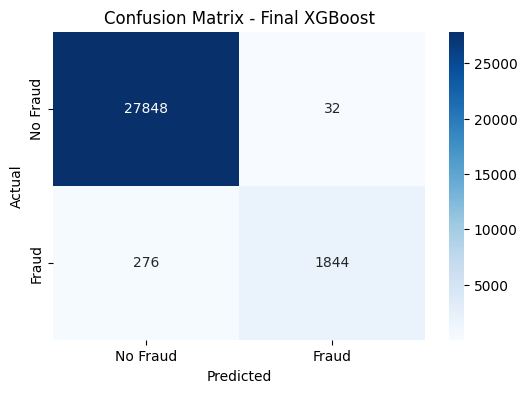

In [43]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_final)

# Plot Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["No Fraud", "Fraud"], yticklabels=["No Fraud", "Fraud"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Final XGBoost")
plt.show()


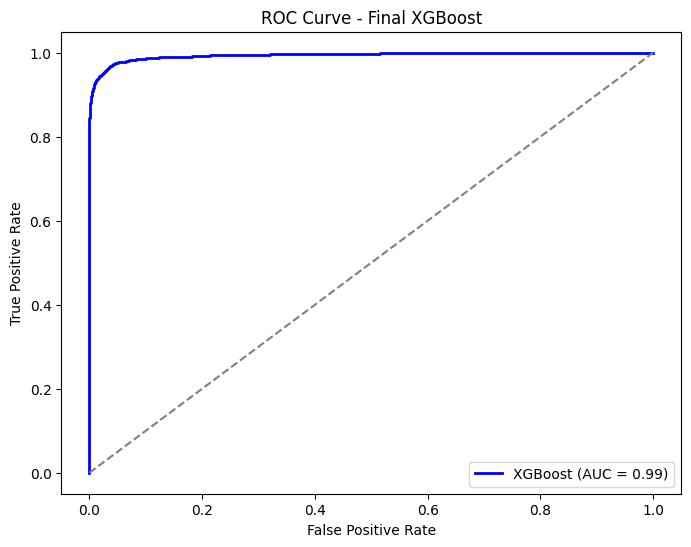


🔹 Area Under ROC Curve (AUC): 0.9941


In [44]:
from sklearn.metrics import roc_curve, auc

# Compute ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_final)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'XGBoost (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Baseline
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Final XGBoost")
plt.legend(loc="lower right")
plt.show()

# Print AUC Score
print(f"\n🔹 Area Under ROC Curve (AUC): {roc_auc:.4f}")


C:\Users\Debrachoubey\AppData\Local\Temp\ipykernel_17440\3204593746.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df.head(15), palette='Blues_r')


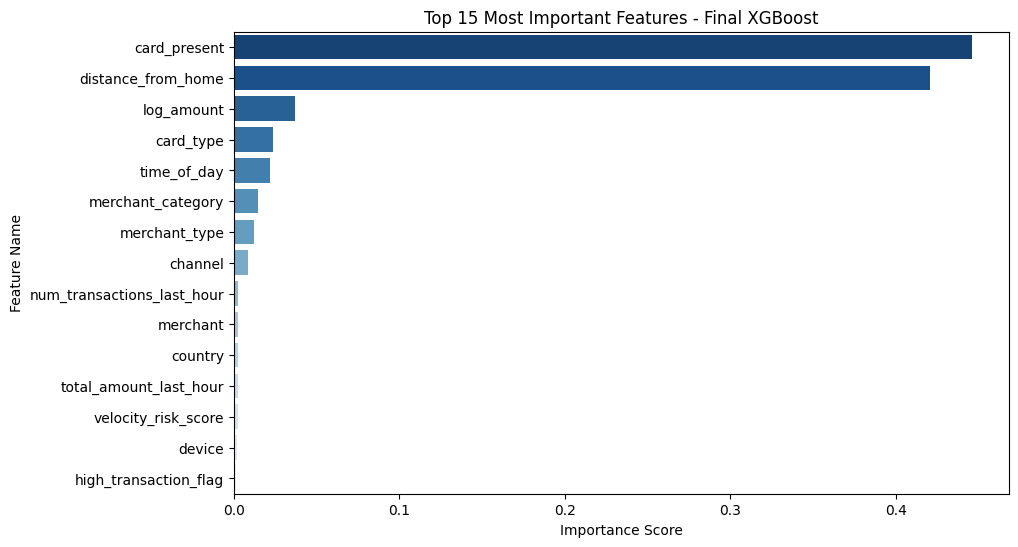

In [45]:
# Get Feature Importance
feature_importance = xgb_final.feature_importances_
features = X_train.columns

# Create DataFrame for Feature Importance
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot Feature Importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(15), palette='Blues_r')
plt.title("Top 15 Most Important Features - Final XGBoost")
plt.xlabel("Importance Score")
plt.ylabel("Feature Name")
plt.show()


In [46]:
from sklearn.neighbors import LocalOutlierFactor

# Initialize LOF model
lof_model = LocalOutlierFactor(n_neighbors=20, contamination=0.05)  # Contamination ~5% fraud expected

# Fit LOF on the training data (excluding target column)
lof_predictions = lof_model.fit_predict(X_train)

# Convert LOF output (-1 for anomalies, 1 for normal) into fraud labels
lof_fraud_labels = (lof_predictions == -1).astype(int)  # Convert -1 (outliers) to 1 (fraud)


In [47]:
from sklearn.ensemble import IsolationForest

# Initialize Isolation Forest
iso_forest = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)

# Fit on the training data
iso_forest.fit(X_train)

# Predict fraud probability (-1 = anomaly, 1 = normal)
iso_predictions = iso_forest.predict(X_train)

# Convert predictions to fraud labels
iso_fraud_labels = (iso_predictions == -1).astype(int)  # Convert -1 to 1 (fraud)


In [48]:
import numpy as np
from sklearn.ensemble import VotingClassifier

# Convert anomaly detection predictions into DataFrame format
X_train_ensemble = np.column_stack([lof_fraud_labels, iso_fraud_labels, xgb_final.predict(X_train)])
X_test_ensemble = np.column_stack([lof_model.fit_predict(X_test) == -1, iso_forest.predict(X_test) == -1, xgb_final.predict(X_test)])

# Target variable remains the same
y_train_ensemble = y_train
y_test_ensemble = y_test


In [49]:
from sklearn.ensemble import RandomForestClassifier

# Initialize a Voting Classifier with hard voting (majority rule)
voting_classifier = VotingClassifier(
    estimators=[
        ('lof', RandomForestClassifier(n_estimators=100, random_state=42)),  # Convert LOF to classifier
        ('iso', RandomForestClassifier(n_estimators=100, random_state=42)),  # Convert Isolation Forest to classifier
        ('xgb', xgb_final)  # XGBoost (already trained)
    ],
    voting='hard'  # Majority vote from all models
)

# Train the final classifier
voting_classifier.fit(X_train_ensemble, y_train_ensemble)


C:\Users\Debrachoubey\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:14:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


VotingClassifier(estimators=[('lof', RandomForestClassifier(random_state=42)),
                             ('iso', RandomForestClassifier(random_state=42)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.8, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric='logloss',
                                            feature_...a=0.1,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.1, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=6,
                                            max_leaves=None, min_child_weight=1,
                                            missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...))])

In [51]:
y_pred_ensemble = voting_classifier.predict(X_test_ensemble)


In [52]:
from sklearn.metrics import classification_report

print("\n🔹 Final Hybrid Model Performance:")
print(classification_report(y_test_ensemble, y_pred_ensemble))



🔹 Final Hybrid Model Performance:
              precision    recall  f1-score   support

       False       0.99      1.00      0.99     27880
        True       0.98      0.87      0.92      2120

    accuracy                           0.99     30000
   macro avg       0.99      0.93      0.96     30000
weighted avg       0.99      0.99      0.99     30000



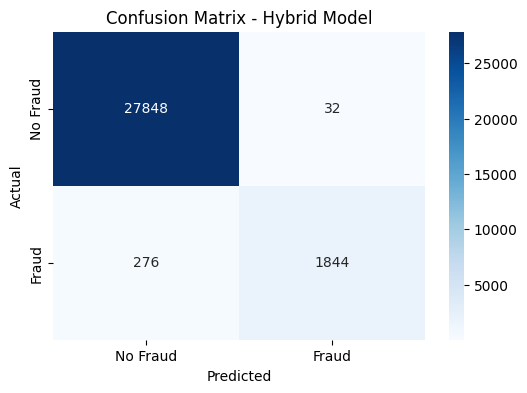

In [53]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate Confusion Matrix
conf_matrix = confusion_matrix(y_test_ensemble, y_pred_ensemble)

# Plot Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["No Fraud", "Fraud"], yticklabels=["No Fraud", "Fraud"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Hybrid Model")
plt.show()


In [54]:
# Initialize a Voting Classifier with soft voting
voting_classifier = VotingClassifier(
    estimators=[
        ('lof', RandomForestClassifier(n_estimators=100, random_state=42)),  # Convert LOF to classifier
        ('iso', RandomForestClassifier(n_estimators=100, random_state=42)),  # Convert Isolation Forest to classifier
        ('xgb', xgb_final)  # XGBoost (already trained)
    ],
    voting='soft'  # Use probabilities instead of majority voting
)

# Train the final classifier
voting_classifier.fit(X_train_ensemble, y_train_ensemble)


C:\Users\Debrachoubey\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:15:10] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


VotingClassifier(estimators=[('lof', RandomForestClassifier(random_state=42)),
                             ('iso', RandomForestClassifier(random_state=42)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.8, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric='logloss',
                                            feature_...
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.1, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=6,
                                            max_leaves=None, min_child_weight=1,
                                            missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...))],
                 voting='soft')

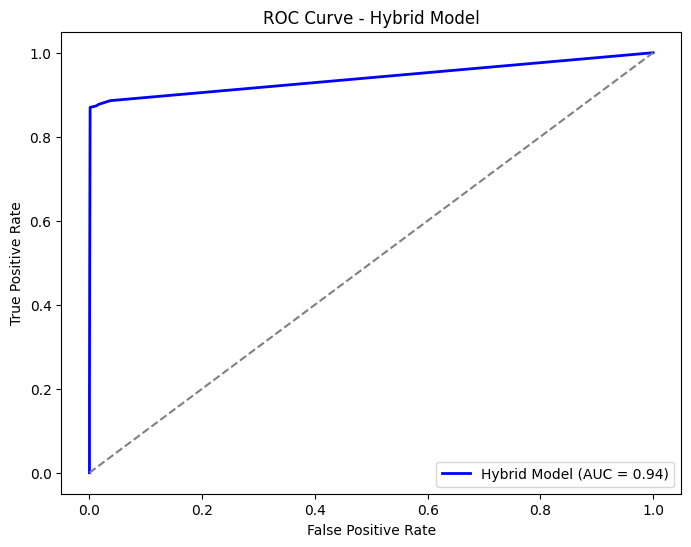


🔹 AUC Score: 0.9402


In [55]:
from sklearn.metrics import roc_curve, auc

# Compute ROC Curve
y_pred_proba_ensemble = voting_classifier.predict_proba(X_test_ensemble)[:, 1]
fpr, tpr, _ = roc_curve(y_test_ensemble, y_pred_proba_ensemble)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'Hybrid Model (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Baseline
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Hybrid Model")
plt.legend(loc="lower right")
plt.show()

print(f"\n🔹 AUC Score: {roc_auc:.4f}")


In [56]:
# Get fraud probability predictions
y_pred_proba = voting_classifier.predict_proba(X_test_ensemble)[:, 1]  # Get fraud probability

# Lower threshold to catch more fraud cases
threshold = 0.4  # Default is 0.5, reducing to 0.4 improves recall
y_pred_adjusted = (y_pred_proba >= threshold).astype(int)  # Convert probabilities to binary fraud labels


In [57]:
# Adjust voting classifier with rebalanced weights
voting_classifier = VotingClassifier(
    estimators=[
        ('lof', RandomForestClassifier(n_estimators=100, random_state=42)),  
        ('iso', RandomForestClassifier(n_estimators=100, random_state=42)),  
        ('xgb', xgb_final)  
    ],
    voting='soft',  # Use soft voting for probabilities
    weights=[2, 2, 3]  # Balanced: XGBoost (3), LOF (2), Isolation Forest (2)
)

# Retrain with new weights
voting_classifier.fit(X_train_ensemble, y_train_ensemble)

# Predict with new model
y_pred_adjusted = (voting_classifier.predict_proba(X_test_ensemble)[:, 1] >= threshold).astype(int)


C:\Users\Debrachoubey\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:15:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [58]:
from sklearn.metrics import classification_report

print("\n🔹 Fine-Tuned Hybrid Model Performance:")
print(classification_report(y_test_ensemble, y_pred_adjusted))



🔹 Fine-Tuned Hybrid Model Performance:
              precision    recall  f1-score   support

       False       0.99      1.00      0.99     27880
        True       0.98      0.87      0.92      2120

    accuracy                           0.99     30000
   macro avg       0.99      0.93      0.96     30000
weighted avg       0.99      0.99      0.99     30000



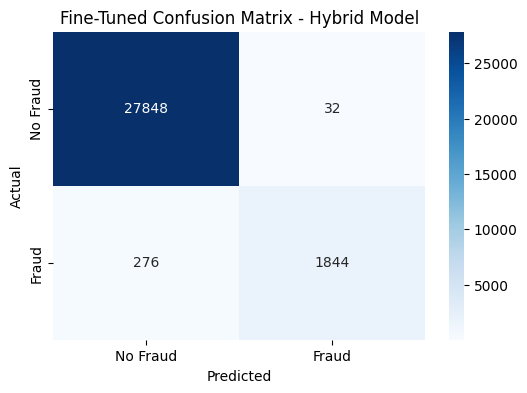

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Generate Confusion Matrix
conf_matrix = confusion_matrix(y_test_ensemble, y_pred_adjusted)

# Plot Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["No Fraud", "Fraud"], yticklabels=["No Fraud", "Fraud"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Fine-Tuned Confusion Matrix - Hybrid Model")
plt.show()


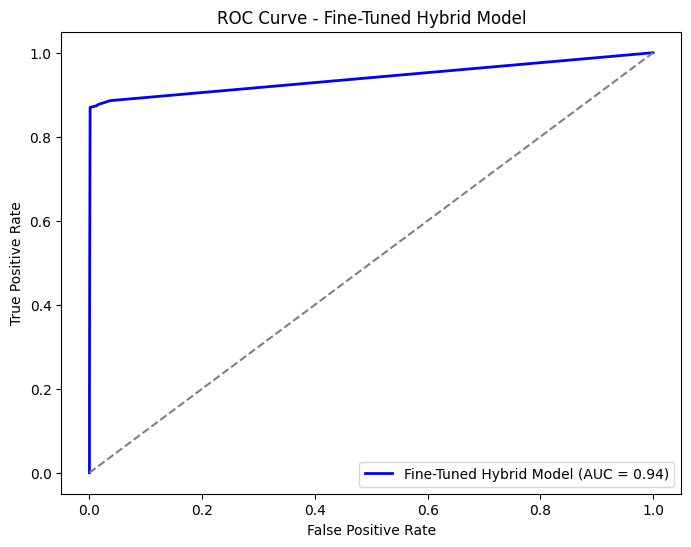


🔹 AUC Score After Fine-Tuning: 0.9402


In [60]:
from sklearn.metrics import roc_curve, auc

# Compute ROC Curve
fpr, tpr, _ = roc_curve(y_test_ensemble, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'Fine-Tuned Hybrid Model (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Baseline
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Fine-Tuned Hybrid Model")
plt.legend(loc="lower right")
plt.show()

print(f"\n🔹 AUC Score After Fine-Tuning: {roc_auc:.4f}")


In [61]:
import joblib

# Save the Voting Classifier model
joblib.dump(voting_classifier, "hybrid_fraud_model.pkl")

print(" Hybrid Model Saved Successfully!")


 Hybrid Model Saved Successfully!


In [62]:
# Load the saved model
loaded_model = joblib.load("hybrid_fraud_model.pkl")

# Check if it's loaded correctly
print("Model Loaded Successfully!")


Model Loaded Successfully!


In [ ]:
import joblib

# Load the saved hybrid fraud detection model
loaded_model = joblib.load("hybrid_fraud_model.pkl")

print("✅ Model Loaded Successfully!")


In [ ]:
print("X_train_ensemble shape:", X_train_ensemble.shape)
print("X_test_ensemble shape:", X_test_ensemble.shape)


In [ ]:
print("df_selected shape:", df_selected.shape)  # Should be larger than X_train_ensemble


In [82]:
print("X_train_ensemble shape:", X_train_ensemble.shape)
print("X_test_ensemble shape:", X_test_ensemble.shape)
print("df_selected shape (original dataset before transformation):", df_selected.shape)


X_train_ensemble shape: (70000, 3)
X_test_ensemble shape: (30000, 3)
df_selected shape (original dataset before transformation): (100000, 19)


In [83]:
# Extract feature names from df_selected if available
feature_names = df_selected.columns.tolist()[:X_train_ensemble.shape[1]]

print("Feature Names Retrieved:", feature_names)


Feature Names Retrieved: ['merchant_category', 'merchant_type', 'merchant']


In [85]:
import pandas as pd

# Convert training and test sets to DataFrame using correct column names
X_train_ensemble_df = pd.DataFrame(X_train_ensemble, columns=feature_names)
X_test_ensemble_df = pd.DataFrame(X_test_ensemble, columns=feature_names)

# Select the first 5 test transactions
sample_transaction = X_test_ensemble_df.iloc[:10]

# Display the selected transactions
pd.set_option('display.max_columns', None)
print("🔹 Sample Transactions for Testing:")
print(sample_transaction)


🔹 Sample Transactions for Testing:
   merchant_category  merchant_type  merchant
0                  0              0         0
1                  0              0         0
2                  0              0         0
3                  0              0         0
4                  1              0         1
5                  0              0         0
6                  0              0         0
7                  0              0         0
8                  0              0         0
9                  0              0         0


In [86]:
# Make fraud predictions
sample_prediction = loaded_model.predict(sample_transaction)

# Print the results
print("🔹 Sample Transactions Fraud Predictions:")
for i, pred in enumerate(sample_prediction):
    status = "Fraud" if pred == 1 else "Legit"
    print(f"Transaction {i+1}: {status}")


🔹 Sample Transactions Fraud Predictions:
Transaction 1: Legit
Transaction 2: Legit
Transaction 3: Legit
Transaction 4: Legit
Transaction 5: Fraud
Transaction 6: Legit
Transaction 7: Legit
Transaction 8: Legit
Transaction 9: Legit
Transaction 10: Legit


C:\Users\Debrachoubey\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\Debrachoubey\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [88]:
# Get actual fraud labels for these transactions
actual_labels = y_test_ensemble.iloc[:10].values  # Get actual fraud labels for the same 5 transactions

# Print actual vs predicted values
print("\n Model Predictions vs Actual Labels:")
for i in range(len(sample_transaction)):
    pred_status = "Fraud" if sample_prediction[i] == 1 else "Legit"
    actual_status = "Fraud" if actual_labels[i] == 1 else "Legit"
    print(f"Transaction {i+1}: Predicted = {pred_status}, Actual = {actual_status}")



 Model Predictions vs Actual Labels:
Transaction 1: Predicted = Legit, Actual = Legit
Transaction 2: Predicted = Legit, Actual = Legit
Transaction 3: Predicted = Legit, Actual = Legit
Transaction 4: Predicted = Legit, Actual = Legit
Transaction 5: Predicted = Fraud, Actual = Fraud
Transaction 6: Predicted = Legit, Actual = Legit
Transaction 7: Predicted = Legit, Actual = Legit
Transaction 8: Predicted = Legit, Actual = Legit
Transaction 9: Predicted = Legit, Actual = Legit
Transaction 10: Predicted = Legit, Actual = Legit


In [89]:
# Get fraud probability scores
sample_proba = loaded_model.predict_proba(sample_transaction)[:, 1]  # Probability of being fraud

# Print probability scores
print("\n🔹 Sample Fraud Probabilities:")
for i, prob in enumerate(sample_proba):
    print(f"Transaction {i+1}: Fraud Probability = {prob:.2f}")



🔹 Sample Fraud Probabilities:
Transaction 1: Fraud Probability = 0.01
Transaction 2: Fraud Probability = 0.01
Transaction 3: Fraud Probability = 0.01
Transaction 4: Fraud Probability = 0.01
Transaction 5: Fraud Probability = 1.00
Transaction 6: Fraud Probability = 0.01
Transaction 7: Fraud Probability = 0.01
Transaction 8: Fraud Probability = 0.01
Transaction 9: Fraud Probability = 0.01
Transaction 10: Fraud Probability = 0.01


C:\Users\Debrachoubey\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\Debrachoubey\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [74]:
import joblib

# Save the final model
joblib.dump(loaded_model, "final_hybrid_fraud_model.pkl")

print("✅ Final Model Saved Successfully!")


✅ Final Model Saved Successfully!


In [75]:
# Load the saved model for real-time predictions
final_model = joblib.load("final_hybrid_fraud_model.pkl")

print("Final Model Loaded Successfully!")


Final Model Loaded Successfully!
